In [82]:
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from dataset import TreeStimuli, Neuron, Ensemble, LinearNeuron, InteractionNeuron,LogisticNeuron, UnivariateGaussianNeuron, MultivariateGaussianNeuron
from copy import deepcopy
from functools import partial
import random

# Synthetic dataset generation

## Stimuli space
First we generate a set of tree stimuli of varying leafiness and branchiness. 
Here we didn't specify the feature vector of leafiness and branchiness, and it will by default 
create 40 stimuli from factorial combinations of 20 levels of leafiness and 2 levels of branchiness


In [17]:
Trees = TreeStimuli()
Trees.stimuli.shape

(40, 2)

## Define different types of neurons and ensembles

One instantiation of the various `**Neuron` class create a neuron with parameterized firing function. Linear/nonlinear pure/mixed selectivity can be achieved by different class and different parameters (see documentation for further details). 

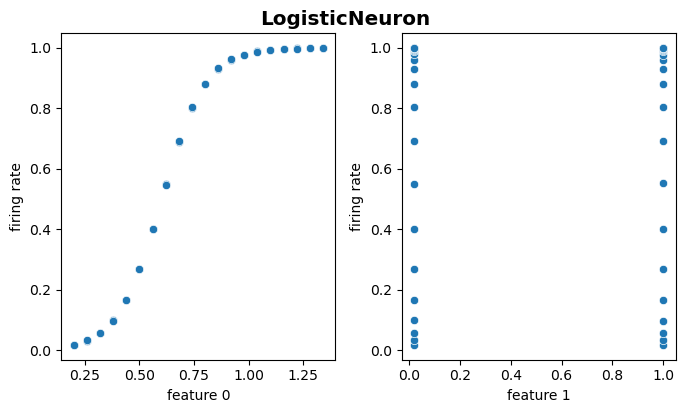

In [18]:
logisiticneuron_param = {"w":np.array([[1],[0]]), "k":10, "x0":0.6}
_ = LogisticNeuron(**logisiticneuron_param).plot_firingrate(Trees.stimuli)


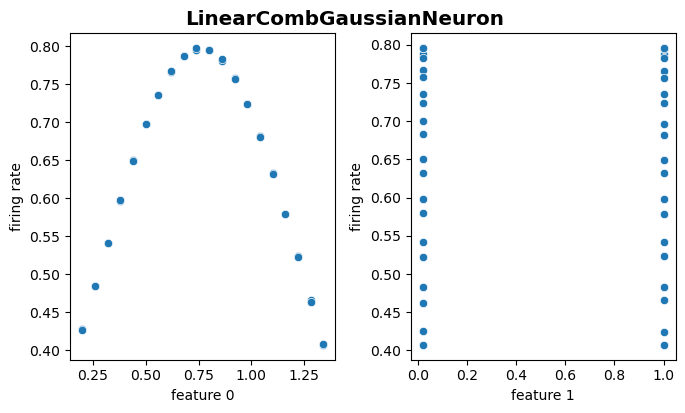

In [19]:
# Alternatively, new neuron class can be created as needed.
class LinearCombGaussianNeuron(Neuron):
  def __init__(self,w,mus,sigs,noise_mu:int=0,noise_sig:int=0.001) -> None:
    super().__init__(noise_mu,noise_sig)
    gaussians = [partial(lambda x: scipy.stats.norm(mu,sig).pdf(x)) for (mu,sig) in zip([0.33,0.76],[.22,.5])]
    self.activate = lambda stimuli: np.array([gaussian(stimuli[:,j]) for j,gaussian in enumerate(gaussians)]).T@w
    self.firing_description = f"feature weights = {w} \nmultivariate gaussian centered around {mus},\n sigma={sigs} \n"

class LinearCombLogisticNeuron(Neuron):
  def __init__(self,w,ks,x0s,noise_mu=0,noise_sig=1) -> None:
    super().__init__(noise_mu,noise_sig)
    sigmoids = [partial(lambda x: 1/(1+np.exp(-k*(x-x0))))for (k,x0) in enumerate(zip(ks,x0s))]
    self.activate = lambda stimuli: np.array([sigmoid(stimuli[:,j]) for j,sigmoid in enumerate(sigmoids)])@w
    self.firing_description = f"feature weights = {w} \n logistic function k={ks},\n x0={x0s} \n"

lcgauneuron_param = {"w":np.array([[1],[0]]), "mus":[0.33,0.76], "sigs":[0.2,0.5]}
_ = LinearCombGaussianNeuron(**lcgauneuron_param).plot_firingrate(Trees.stimuli)

## Ensembles

An ensemble consists of multiple neurons, each with different firing functions. Here we set up different ensembles with either linear/nonlinear pure/mixed selectivity. Each has two neurons, and we can visualize the firing space in 2D and compare with the 2D Tree stimuli space


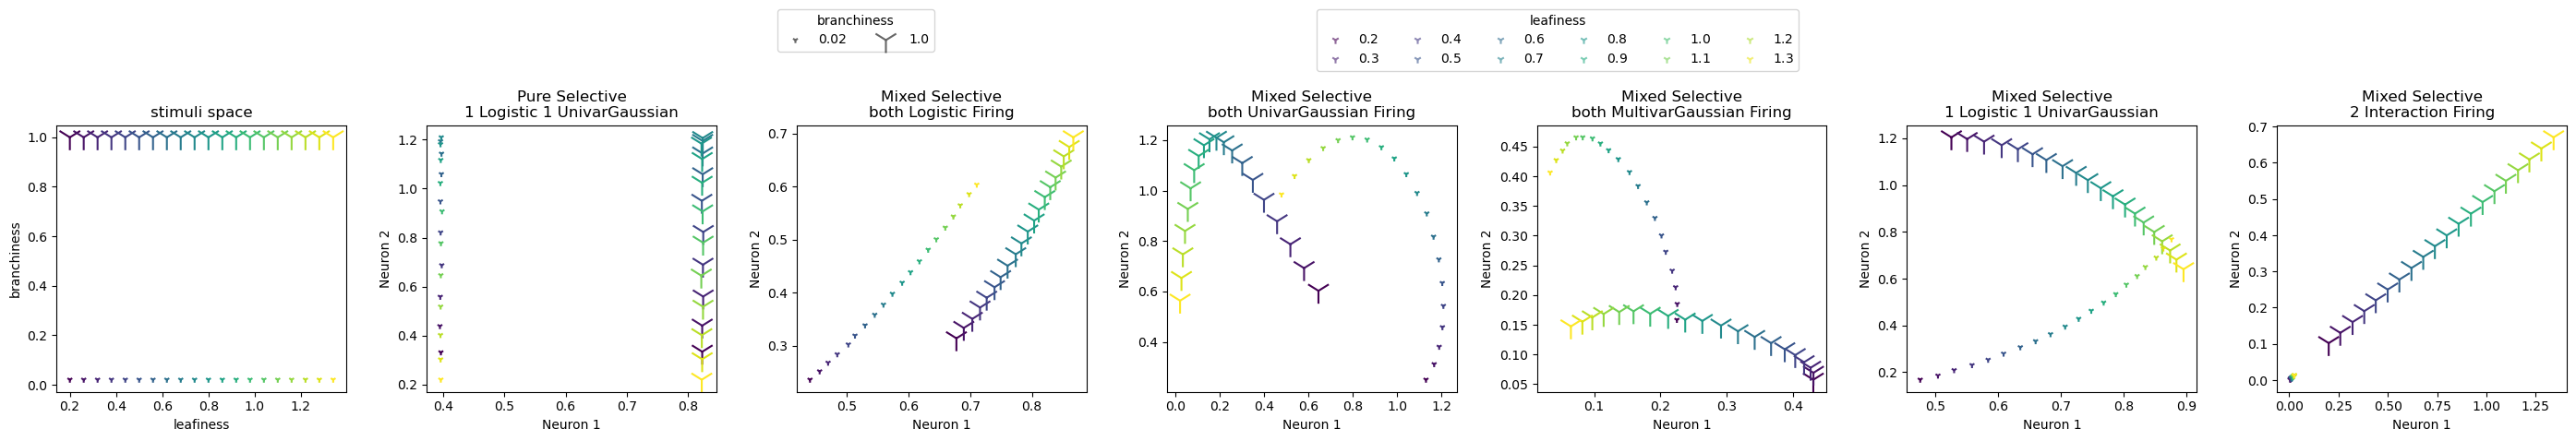

In [20]:

## Ensemble 1:  2 pure selective - logistic+gaussian
classes = [LogisticNeuron,UnivariateGaussianNeuron]
params = [{"w":np.array([[0],[1]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[1],[0]]),
           "mu":0.73,
           "sig":0.33}]
PureSelectiveMixEnsemble = Ensemble(classes,params)
PureSelectiveMixEnsemble.fire(Trees.stimuli)

## Ensemble 2:  2 mixed selective - logistic
classes = [LogisticNeuron,LogisticNeuron]
params = [{"w":np.array([[0.5],[0.5]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[0.7],[0.2]]),
           "k":2,
           "x0":0.73}]
MixSelectiveLogisticEnsemble = Ensemble(classes,params)
MixSelectiveLogisticEnsemble.fire(Trees.stimuli)

## Ensemble 3:  2 mixed selective - univariate gaussian
classes = [UnivariateGaussianNeuron,UnivariateGaussianNeuron]
params = [{"w":np.array([[0.5],[0.5]]),
           "mu":0.23,
           "sig":0.33},
          {"w":np.array([[0.7],[0.2]]),
           "mu":0.73,
           "sig":0.33}]
MixSelectiveUGaussianEnsemble = Ensemble(classes,params)
MixSelectiveUGaussianEnsemble.fire(Trees.stimuli)

## Ensemble 4:  2 mixed selective - multivariate gaussian
classes = [MultivariateGaussianNeuron,MultivariateGaussianNeuron]
params = [{"mus":[0.23,0.73],
           "cov":0.33},
          {"mus":[1.04,0.17],
           "cov":0.33}]
MixSelectiveMGaussianEnsemble = Ensemble(classes,params)
MixSelectiveMGaussianEnsemble.fire(Trees.stimuli)


## Ensemble 5:  2 mixed selective - logistic+gaussian
classes = [LogisticNeuron,UnivariateGaussianNeuron]
params = [{"w":np.array([[0.9],[0.1]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[0.3],[0.7]]),
           "mu":0.73,
           "sig":0.33}]
MixSelectiveMixEnsemble = Ensemble(classes,params)
MixSelectiveMixEnsemble.fire(Trees.stimuli)


## Ensemble 6:  2 interactioin neuron
classes = [InteractionNeuron,InteractionNeuron]
params = [{"w":1,
           },
          {"w":0.5,
           }]
MixSelectiveInteractionEnsemble = Ensemble(classes,params)
MixSelectiveInteractionEnsemble.fire(Trees.stimuli)

TwoNeuronSpaces = {
    "stimuli space":Trees.stimuli,
    "Pure Selective - 1 Logistic 1 UnivarGaussian":PureSelectiveMixEnsemble.fire(Trees.stimuli),
    "Mixed Selective - both Logistic Firing": MixSelectiveLogisticEnsemble.fire(Trees.stimuli),
    "Mixed Selective - both UnivarGaussian Firing": MixSelectiveUGaussianEnsemble.fire(Trees.stimuli),
    "Mixed Selective - both MultivarGaussian Firing": MixSelectiveMGaussianEnsemble.fire(Trees.stimuli),
    "Mixed Selective - 1 Logistic 1 UnivarGaussian": MixSelectiveMixEnsemble.fire(Trees.stimuli),
    "Mixed Selective - 2 Interaction Firing": MixSelectiveInteractionEnsemble.fire(Trees.stimuli),
}

fig_fspace,ax_fspace = plt.subplots(1,len(TwoNeuronSpaces),figsize=(4*(len(TwoNeuronSpaces)),4))
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    splot=ax_fspace[js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax_fspace[js].set_title(s_name.replace(' - ','\n'))
    if "stimuli" in s_name:
        ax_fspace[js].set_xlabel(Trees.featurenames[0])
        ax_fspace[js].set_ylabel(Trees.featurenames[1])
    else:
        ax_fspace[js].set_xlabel("Neuron 1")
        ax_fspace[js].set_ylabel("Neuron 2")
hs, ls = splot.legend_elements(prop="sizes", alpha=0.6)
ls = np.unique(Trees.stimuli[:,1])#use original feature value as label
hc, lc = splot.legend_elements(prop="colors", alpha=0.6)
fig_fspace.legend(hs,ls, loc='outside upper left',bbox_to_anchor=(0.3,1.2),ncol=6, title=Trees.featurenames[1])
fig_fspace.legend(hc,lc, loc='outside upper right',bbox_to_anchor=(0.7,1.2),ncol=6, title=Trees.featurenames[0])
fig_fspace.tight_layout()

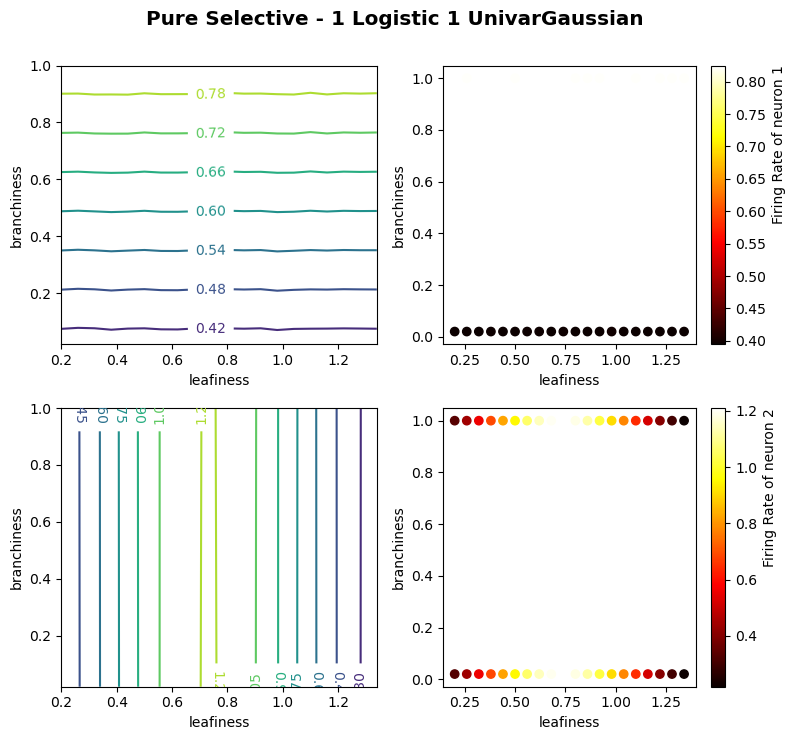

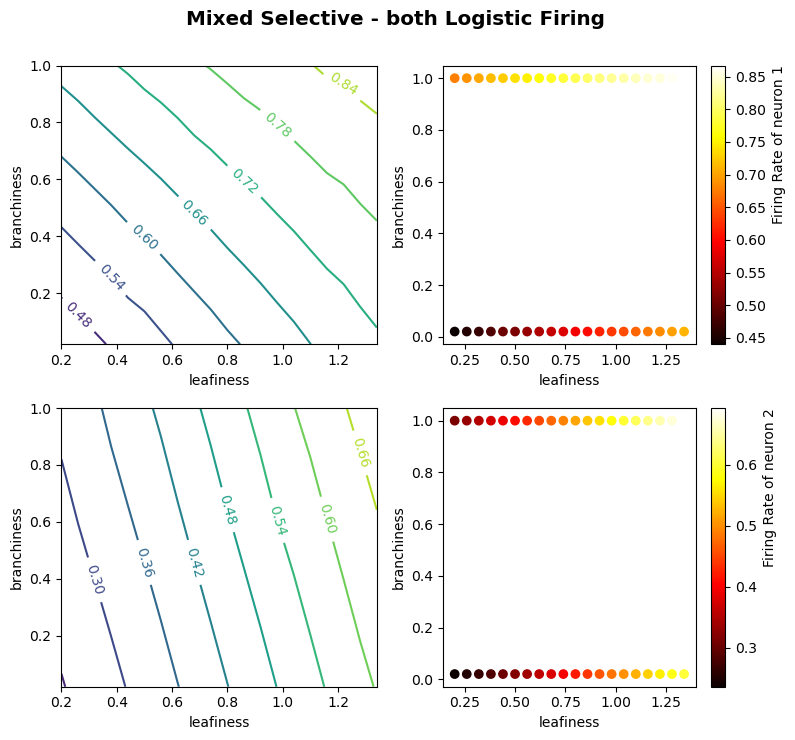

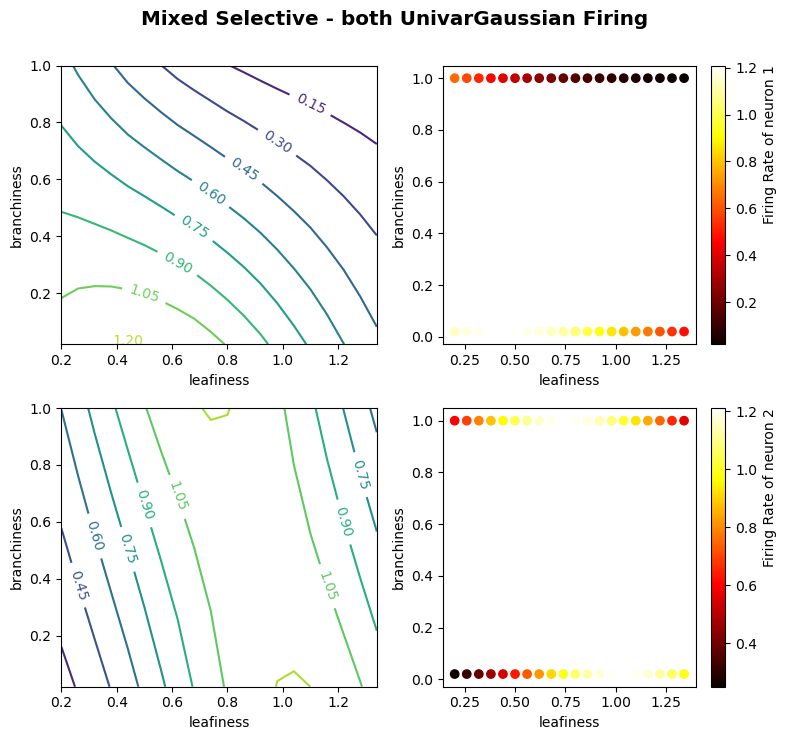

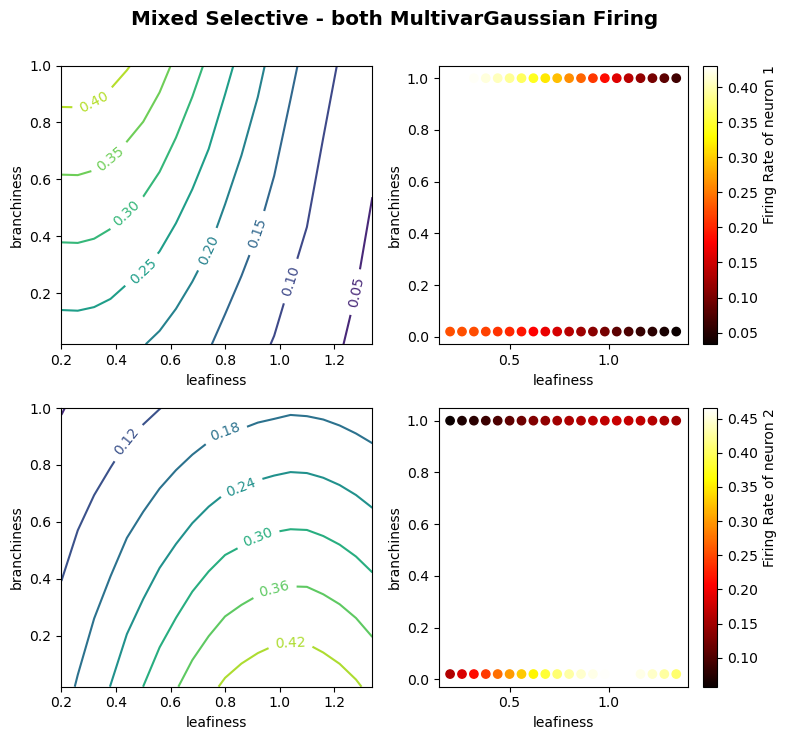

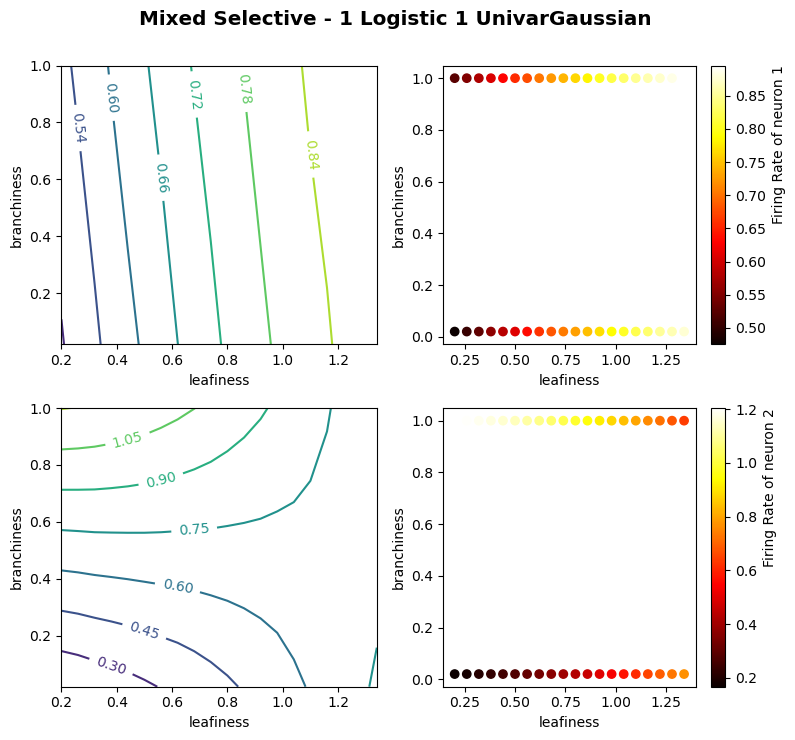

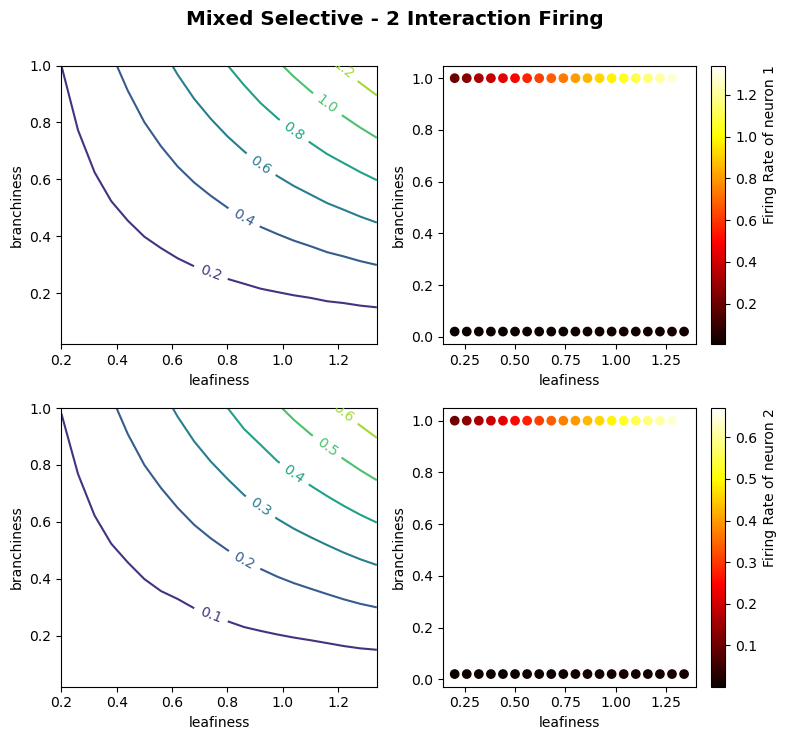

In [21]:
## visualisations with contour plots
stim_space = deepcopy(Trees.stimuli)
new_shape=tuple([np.size(x) for x in Trees.features])
F1, F2 = np.reshape(stim_space[:,0],new_shape),np.reshape(stim_space[:,1],new_shape)
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    if s_name != "stimuli space":
        firing_space = s_mat
        fig, ax = plt.subplots(2,2,figsize=(8,7))
        for j in range(firing_space.shape[1]):
            H = np.reshape(firing_space[:,j],new_shape)
            cs=ax[j,0].contour(F1, F2, H)
            ax[j,0].clabel(cs, inline=True, fontsize=10)
            sc=ax[j,1].scatter(x=stim_space[:,0],y=stim_space[:,1],c=firing_space[:,j],cmap="hot")
            cbar = fig.colorbar(sc)
            cbar.set_label(f"Firing Rate of neuron {j+1}", loc='top')#
            ax[j,0].set_xlabel("leafiness")
            ax[j,1].set_xlabel("leafiness")
            ax[j,0].set_ylabel("branchiness")
            ax[j,1].set_ylabel("branchiness")
        fig.tight_layout()
        fig.suptitle(s_name,fontweight="bold",fontsize="x-large",position=(0.5,1.05))

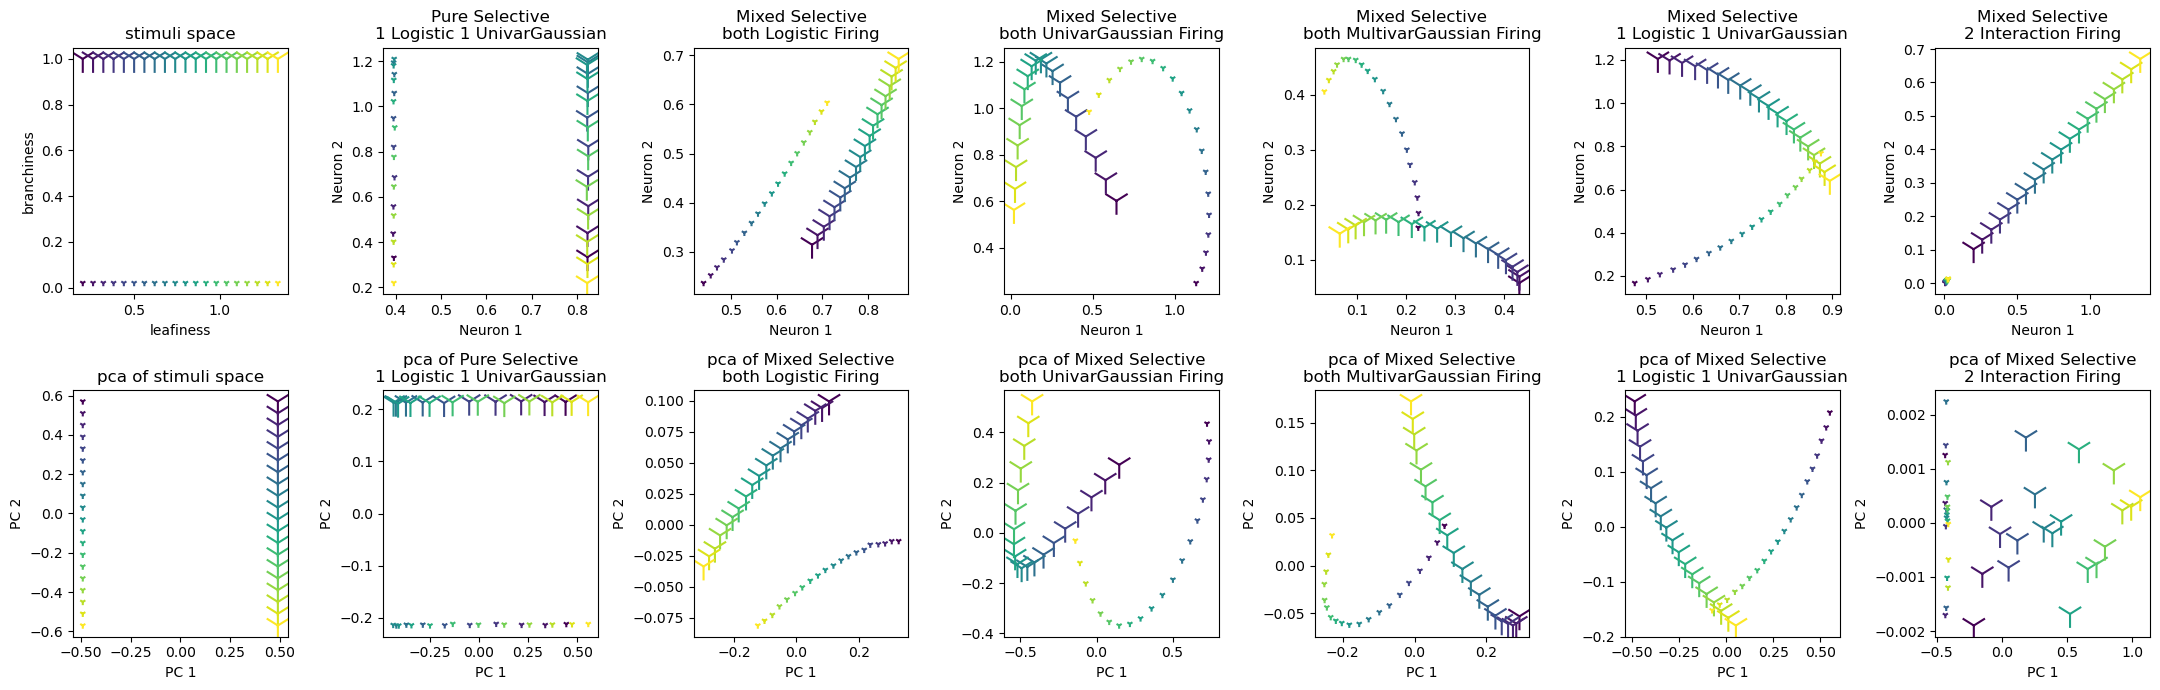

In [40]:
## PCA on different neurons
from sklearn.decomposition import PCA
pca_sapce = {}
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    pca_sapce[s_name] = PCA(n_components=2).fit_transform(s_mat)

fig_fspace,ax_fspace = plt.subplots(2,len(TwoNeuronSpaces),figsize=(3.1*len(TwoNeuronSpaces),7))
for js,(s_name,s_mat) in enumerate(TwoNeuronSpaces.items()):
    ax_fspace[0,js].scatter(x=s_mat[:,0],y=s_mat[:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[0,js].set_title(s_name.replace(' - ','\n'))
    ax_fspace[1,js].scatter(x=pca_sapce[s_name][:,0],y=pca_sapce[s_name][:,1],c=stim_space[:,0],s=np.exp(stim_space[:,1]*3+3),marker="1")
    ax_fspace[1,js].set_title('pca of '+s_name.replace(' - ','\n'))
    if "stimuli" in s_name:
        ax_fspace[0,js].set_xlabel(Trees.featurenames[0])
        ax_fspace[0,js].set_ylabel(Trees.featurenames[1])
    else:
        ax_fspace[0,js].set_xlabel("Neuron 1")
        ax_fspace[0,js].set_ylabel("Neuron 2")
    ax_fspace[1,js].set_xlabel("PC 1")
    ax_fspace[1,js].set_ylabel("PC 2")
fig_fspace.tight_layout()

In [41]:

## Ensemble 1:  3 pure selective - logistic
classes = [LogisticNeuron, LogisticNeuron, LogisticNeuron]
params = [{"w":np.array([[0],[0.8]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[0],[0.3]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[1.3],[0]]),
           "k":2,
           "x0":0.23}]
PureSelectiveLogisticEnsemble = Ensemble(classes,params)

## Ensemble 2:  Mixed selective, Linear - logistic
classes = [LogisticNeuron, LogisticNeuron, LogisticNeuron]
params = [{"w":np.array([[0.3],[1]]),
           "k":2,
           "x0":0.23},
          {"w":np.array([[1],[1]]),
           "k":1,
           "x0":0.5},
          {"w":np.array([[1],[0.8]]),
           "k":3,
           "x0":0.1}]
LinearMixSelectiveLogisticEnsemble = Ensemble(classes,params)

## Ensemble 3:  3 mixed selective, Non linear - multivariate gaussian
classes = [MultivariateGaussianNeuron,MultivariateGaussianNeuron,MultivariateGaussianNeuron]
params = [{"mus":[0.23,0.73],
           "cov":0.33},
          {"mus":[1.04,0.17],
           "cov":0.33},
          {"mus":[0.5,0.2],
           "cov":0.33}]
NonlinearMixSelectiveMGaussianEnsemble = Ensemble(classes,params)

ThreeNeuronSpaces = {
    "stimuli space":Trees.stimuli,
    "Pure Selective - 2 Logistic":PureSelectiveLogisticEnsemble.fire(Trees.stimuli),
    "Linear Mixed Selective - both Logistic Firing":LinearMixSelectiveLogisticEnsemble.fire(Trees.stimuli),
    "Nonlinear Mixed Selective - both MGaussian Firing": NonlinearMixSelectiveMGaussianEnsemble.fire(Trees.stimuli)
}


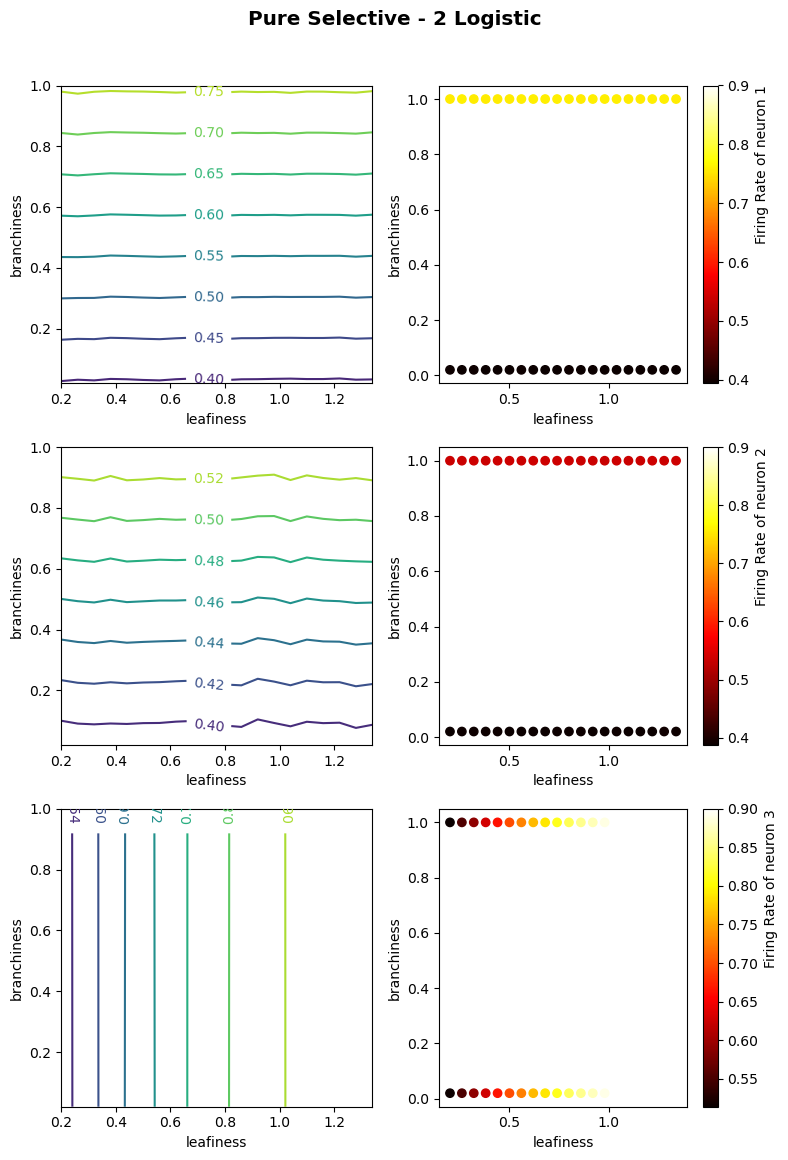

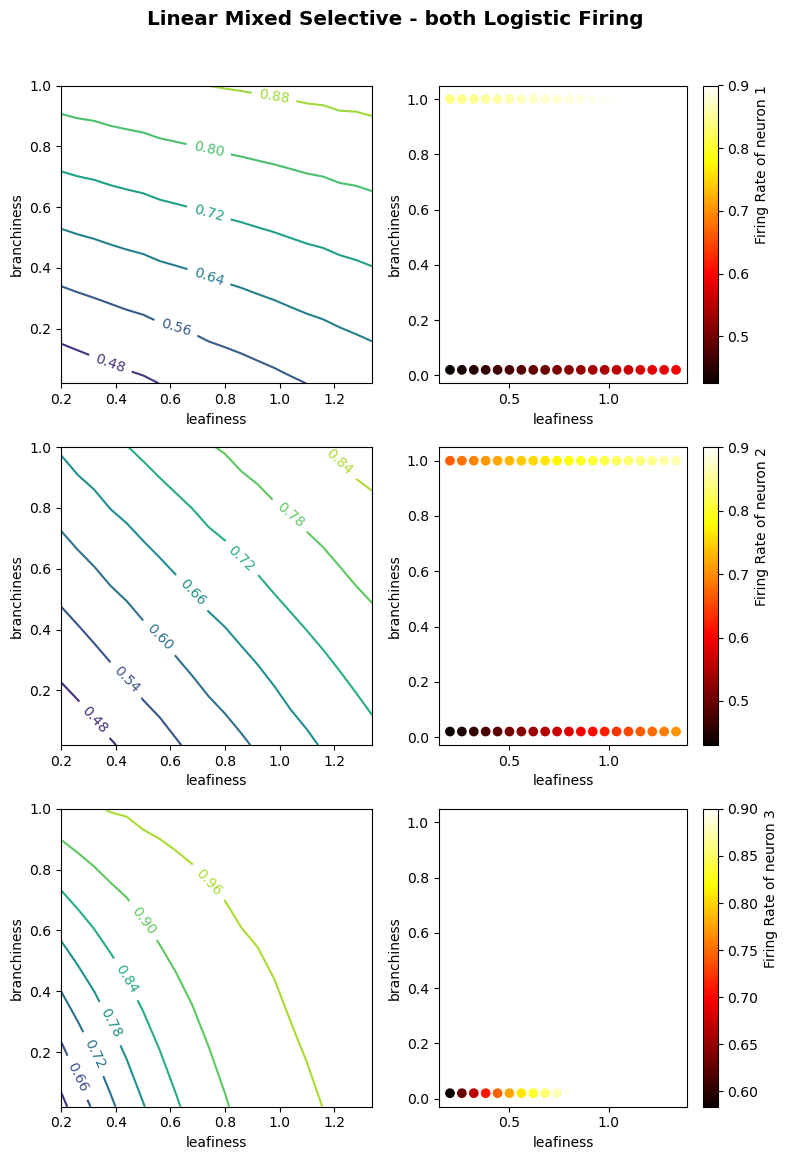

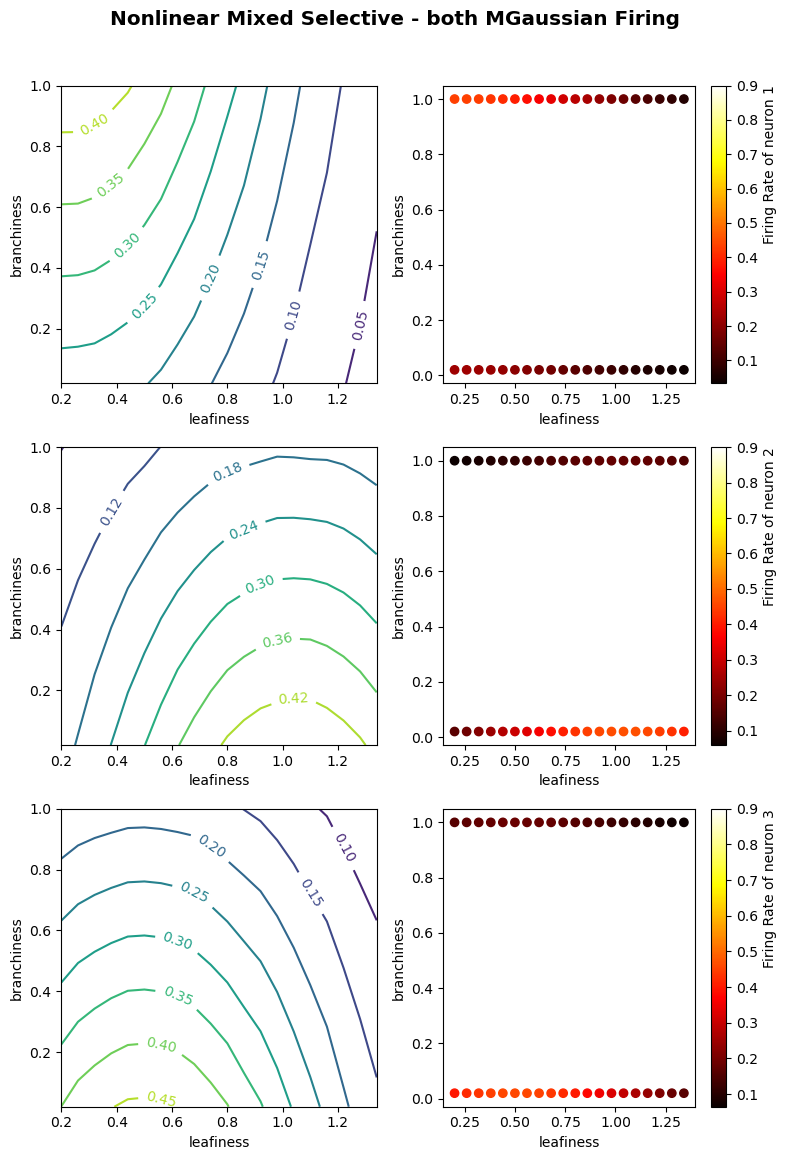

In [42]:
for js,(s_name,s_mat) in enumerate(ThreeNeuronSpaces.items()):
    if s_name != "stimuli space":
        firing_space = s_mat
        fig, ax = plt.subplots(3,2,figsize=(8,11))
        for j in range(firing_space.shape[1]):
            H = np.reshape(firing_space[:,j],new_shape)
            cs=ax[j,0].contour(F1, F2, H)
            ax[j,0].clabel(cs, inline=True, fontsize=10)
            sc=ax[j,1].scatter(x=stim_space[:,0],y=stim_space[:,1],c=firing_space[:,j],cmap="hot", vmax=0.9)
            cbar = fig.colorbar(sc)
            cbar.set_label(f"Firing Rate of neuron {j+1}", loc='top')#
            ax[j,0].set_xlabel("leafiness")
            ax[j,1].set_xlabel("leafiness")
            ax[j,0].set_ylabel("branchiness")
            ax[j,1].set_ylabel("branchiness")
        fig.tight_layout()
        fig.suptitle(s_name,fontweight="bold",fontsize="x-large",position=(0.5,1.05))

stimuli space
Pure Selective - 2 Logistic
Linear Mixed Selective - both Logistic Firing
Nonlinear Mixed Selective - both MGaussian Firing


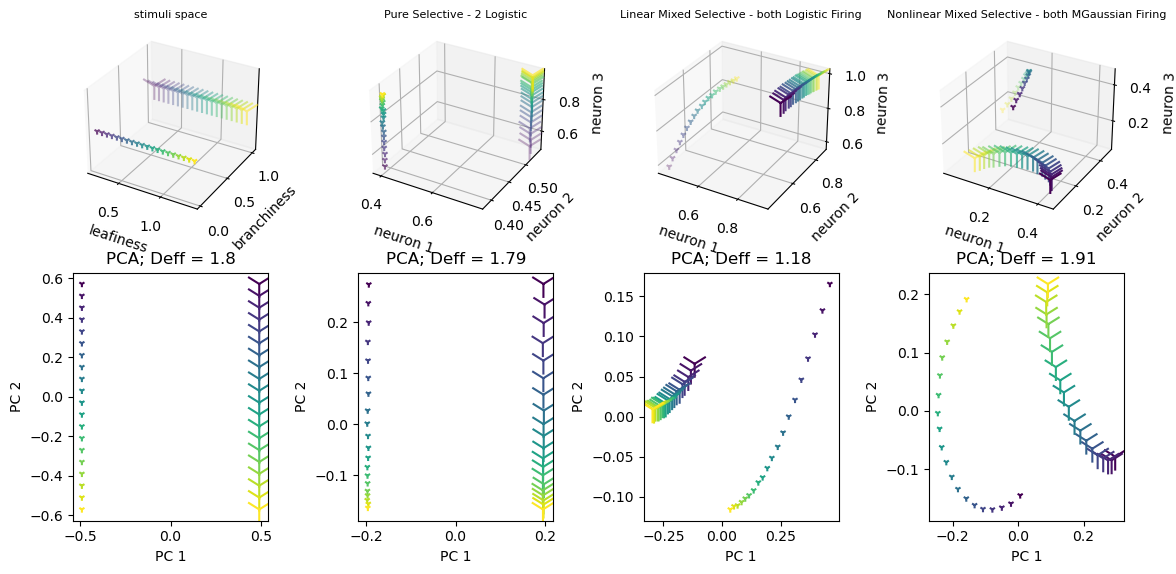

In [86]:
# visualize neural representation - firing response

# compute PCA
from sklearn.decomposition import PCA
pca_space = {}
for js,(s_name,s_mat) in enumerate(ThreeNeuronSpaces.items()):
    pca_space[s_name] = PCA(n_components=2).fit_transform(s_mat)

# Plot firing rates and PCA transformed firing rates
fig = plt.figure(figsize=(5*len(ThreeNeuronSpaces),6))
for js,(s_name,s_mat) in enumerate(ThreeNeuronSpaces.items()):
    print(s_name)
    ax = fig.add_subplot(2, len(TwoNeuronSpaces), js+1, projection='3d')
    if "stimuli" in s_name:
        ax.scatter(s_mat[:,0], s_mat[:,1], [0.5]*s_mat.shape[0], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
        ax.set_xlabel('leafiness')
        ax.set_ylabel('branchiness')
        ax.set_zticks([])
    elif "stimuli" not in s_name:
        ax.scatter(s_mat[:,0], s_mat[:,1], s_mat[:,2], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
        ax.set_xlabel('neuron 1')
        ax.set_ylabel('neuron 2')
        ax.set_zlabel('neuron 3')
    
    ax.set_title(s_name, fontsize=8)
    ax2 = fig.add_subplot(2, len(TwoNeuronSpaces), len(TwoNeuronSpaces)+ js+1)
    ax2.scatter(x=pca_space[s_name][:,0],y=pca_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")
    ax2.set_title(f'PCA; Deff = {round(compute_dimensionality(s_mat),2)}')
fig.tight_layout()

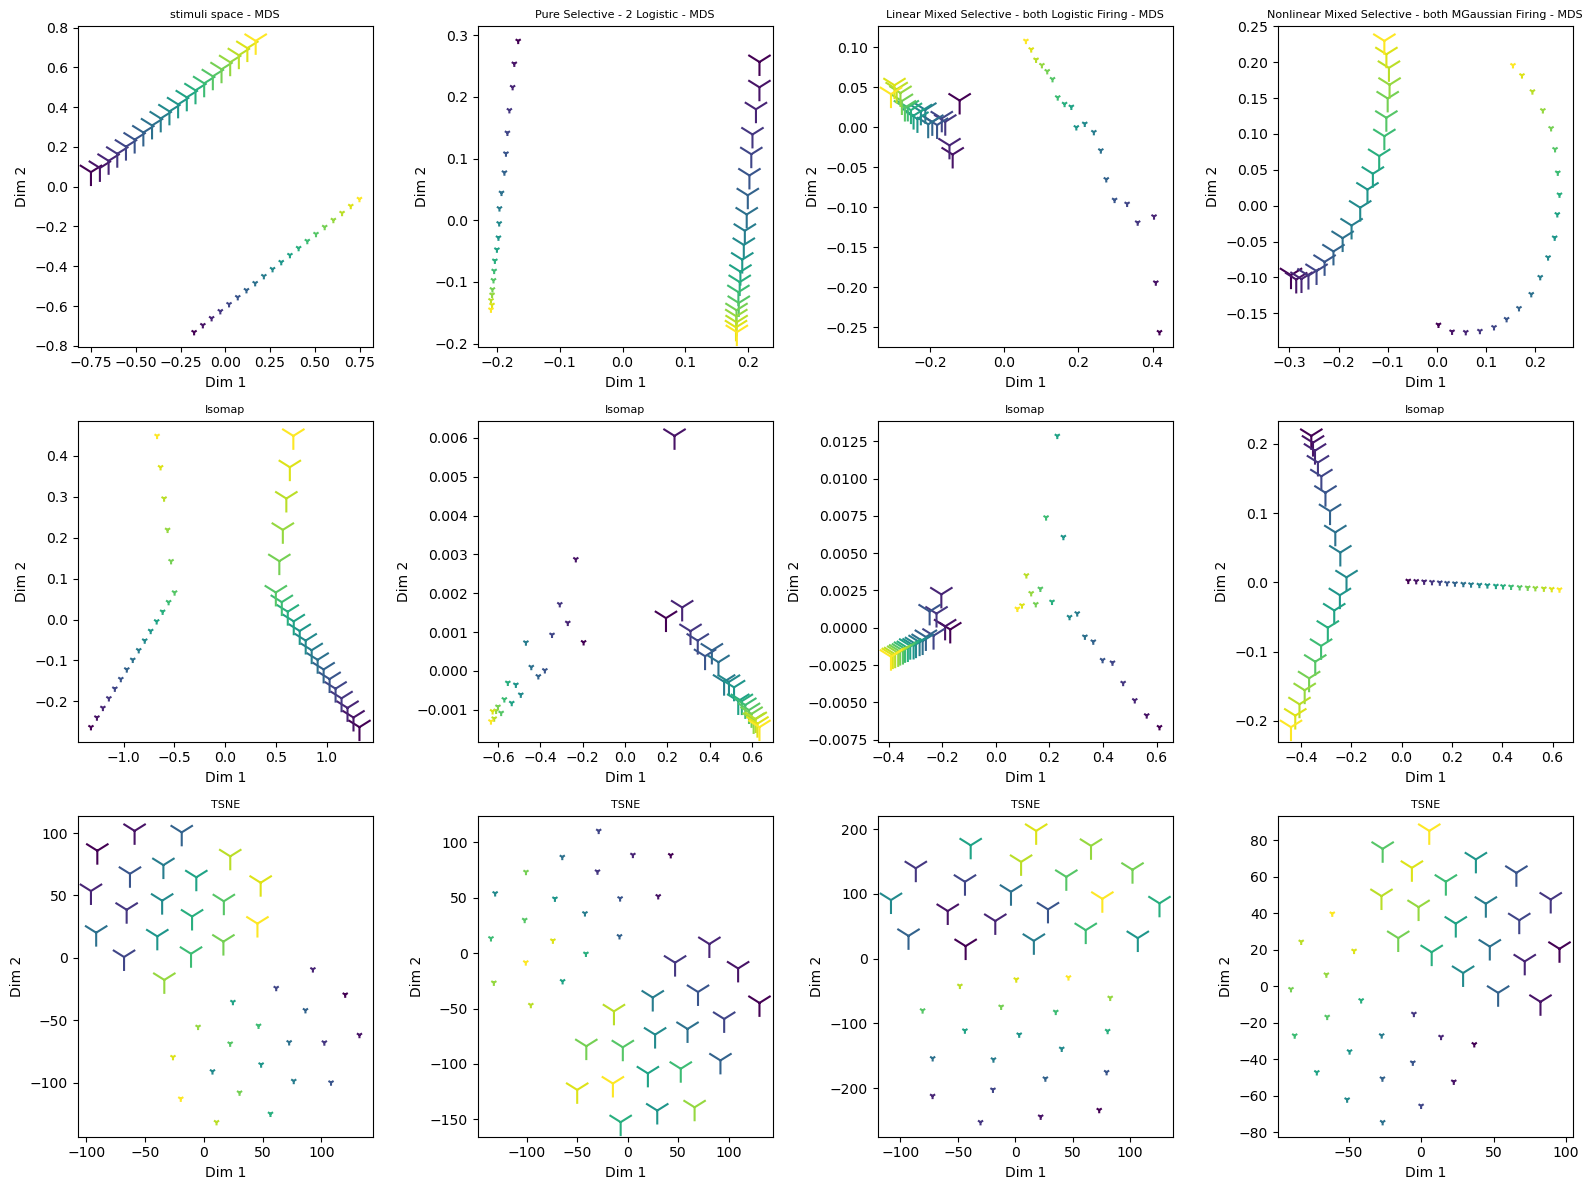

In [87]:
# Non linear dimensionality reduction

from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

# compute MDS

mds_space, isomap_space, tsne_space = {}, {}, {}
for js,(s_name,s_mat) in enumerate(ThreeNeuronSpaces.items()):
    mds_space[s_name] = MDS(n_components=2).fit_transform(s_mat)
    isomap_space[s_name] = Isomap(n_components=2).fit_transform(s_mat)
    tsne_space[s_name] = TSNE(n_components=2).fit_transform(s_mat)

# Plot firing rates and PCA transformed firing rates
fig = plt.figure(figsize=(4*len(ThreeNeuronSpaces), 12))
for js,(s_name,s_mat) in enumerate(ThreeNeuronSpaces.items()):
    
    ax1 = fig.add_subplot(3, len(ThreeNeuronSpaces), js+1)
    ax1.scatter(x=mds_space[s_name][:,0],y=mds_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax1.set_xlabel("Dim 1")
    ax1.set_ylabel("Dim 2")
    ax1.set_title(f'{s_name} - MDS', fontsize=8)
    
    ax2 = fig.add_subplot(3, len(ThreeNeuronSpaces), len(ThreeNeuronSpaces) + js+1)
    ax2.scatter(x=isomap_space[s_name][:,0],y=isomap_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax2.set_xlabel("Dim 1")
    ax2.set_ylabel("Dim 2")
    ax2.set_title(f'Isomap', fontsize=8)
    
    ax2 = fig.add_subplot(3, len(ThreeNeuronSpaces), 2*len(ThreeNeuronSpaces) + js+1)
    ax2.scatter(x=tsne_space[s_name][:,0],y=tsne_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax2.set_xlabel("Dim 1")
    ax2.set_ylabel("Dim 2")
    ax2.set_title(f'TSNE', fontsize=8)
    
fig.tight_layout()

In [ ]:

# variance explained by the first PC and also effective dimensionality
for js,(s_name,s_mat) in enumerate(ThreeNeuronSpaces.items()):
    model = PCA(n_components=2)
    model.fit_transform(s_mat)
    pc1 = model.explained_variance_ratio_
    print(f'{s_name}:\nDeff = {round(compute_dimensionality(s_mat),2)}; PC1 variance = {round(pc1[0],2)}\n')
    

stimuli space:
Deff = 1.8; PC1 variance = 0.67

Pure Selective - 2 Logistic:
Deff = 1.35; PC1 variance = 0.85

Linear Mixed Selective - both Logistic Firing:
Deff = 1.16; PC1 variance = 0.93

Nonlinear Mixed Selective - both MGaussian Firing:
Deff = 1.91; PC1 variance = 0.66



In [30]:
def compute_effective_dimensionality(eigenspectrum: np.ndarray) -> float:
    """ Args: Array of eigenvalue
        Returns: Effective dimension"""
    return (np.sum(eigenspectrum) ** 2) / (eigenspectrum**2).sum()


def compute_dimensionality(firing_matrix):
    """ Computes effective_dimensionality for a matrix of firing rates
    Args: NxM firing rate matrix for a set of N neurons and M inputs
    Returns: effective dimensionality 
    """
    pca = PCA()
    PCs = pca.fit_transform(firing_matrix)
    eigenvalues = pca.explained_variance_
    dim = compute_effective_dimensionality(eigenvalues)
    
    return dim


## Generate data set : Many neurons

In [43]:
## try with N neurons
N = 100


## Ensemble 1:  3 pure selective - logistic
classes = [LogisticNeuron]*N
params = []
for n in range(N):
    params.append({"w":np.array(random.choice([[[0],[1]],[[1],[0]]])),
           "k": random.uniform(1,5),
           "x0":random.uniform(0.1,0.9)})
PS = Ensemble(classes,params)

## Ensemble 2:  Mixed selective, Linear - logistic
classes = [LogisticNeuron]*N
params = []
for n in range(N):
    params.append({"w":np.array([[random.uniform(0,1)], [random.uniform(0,1)]]),
           "k":random.uniform(1,5),
           "x0":random.uniform(0.1,0.9)})
LM = Ensemble(classes,params)

## Ensemble 3:  3 mixed selective, Linear - multivariate gaussian
classes = [MultivariateGaussianNeuron]*N
params = []
for n in range(N):
    params.append({"mus": np.array([random.uniform(0,1),random.uniform(0,1)]),
           "cov":random.uniform(0,1)})
NLM = Ensemble(classes,params)

FiveNeuronSpaces = {
    "stimuli space":Trees.stimuli,
    "Pure Selective":PS.fire(Trees.stimuli),
    "Linear Mixed Selective":LM.fire(Trees.stimuli),
    "Nonlinear Mixed Selective": NLM.fire(Trees.stimuli)
}


stimuli space (40, 2)
Pure Selective (40, 100)
Linear Mixed Selective (40, 100)
Nonlinear Mixed Selective (40, 100)


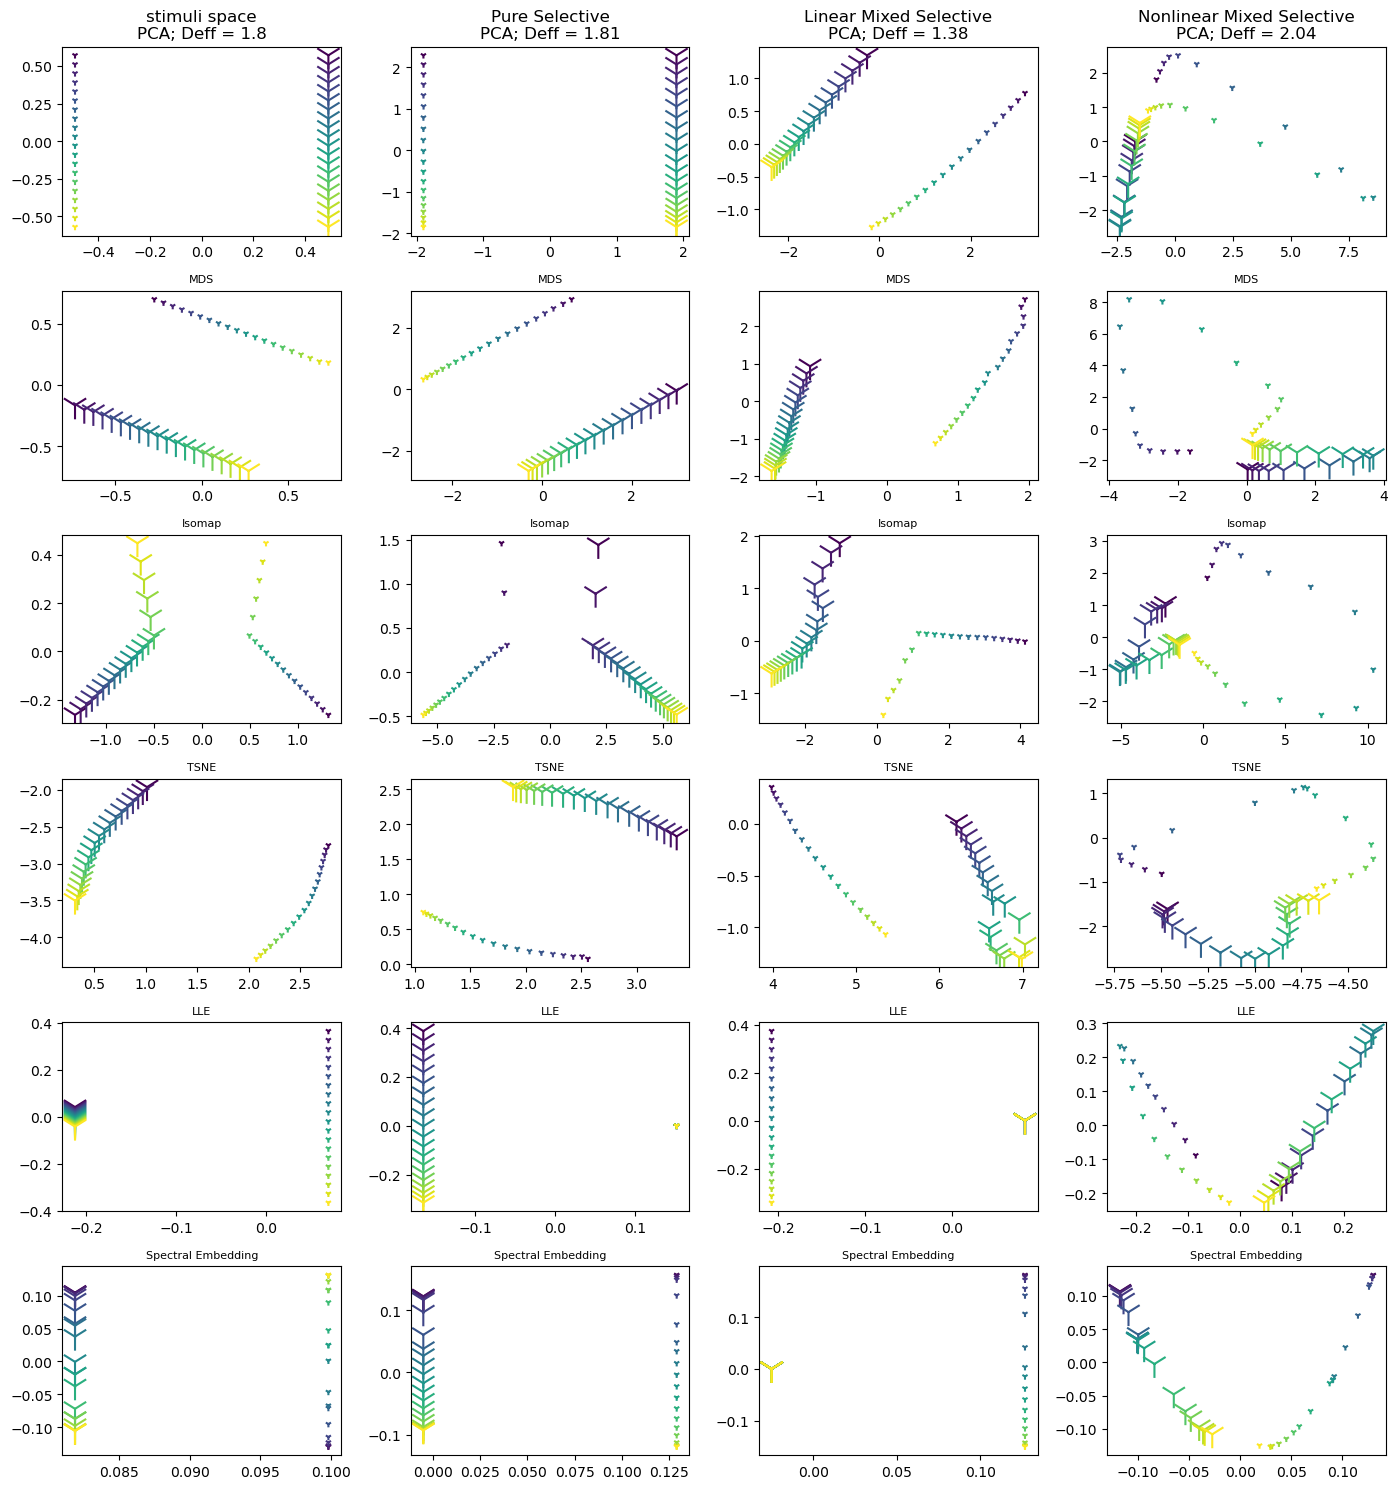

In [93]:
# visualize neural representation - firing response

# compute Dim reduction
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import SpectralEmbedding

# calculate...
pca_space, mds_space, isomap_space, tsne_space, LLE_space, spec_space = {}, {}, {}, {}, {}, {}
for js,(s_name,s_mat) in enumerate(FiveNeuronSpaces.items()):
    pca_space[s_name] = PCA(n_components=2).fit_transform(s_mat)
    mds_space[s_name] = MDS(n_components=2).fit_transform(s_mat)
    isomap_space[s_name] = Isomap(n_components=2, n_neighbors=15).fit_transform(s_mat)
    tsne_space[s_name] = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(s_mat)
    LLE_space[s_name] = LocallyLinearEmbedding(n_components=2).fit_transform(s_mat)
    spec_space[s_name] = SpectralEmbedding(n_components=2).fit_transform(s_mat)

# Plot firing rates and PCA transformed firing rates
fig = plt.figure(figsize=(3.5*len(FiveNeuronSpaces),15))
for jss,(s_name,s_mat) in enumerate(FiveNeuronSpaces.items()):
    print(s_name, s_mat.shape)
    js=jss+1
    ax1 = fig.add_subplot(6, len(FiveNeuronSpaces), js)
    ax1.scatter(x=pca_space[s_name][:,0],y=pca_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax1.set_title(f'{s_name}\nPCA; Deff = {round(compute_dimensionality(s_mat),2)}')

    ax2 = fig.add_subplot(6, len(FiveNeuronSpaces), len(FiveNeuronSpaces) + js)
    ax2.scatter(x=mds_space[s_name][:,0],y=mds_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax2.set_title(f'MDS', fontsize=8)

    ax3 = fig.add_subplot(6, len(FiveNeuronSpaces), 2*len(FiveNeuronSpaces) + js)
    ax3.scatter(x=isomap_space[s_name][:,0],y=isomap_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax3.set_title(f'Isomap', fontsize=8)

    ax3 = fig.add_subplot(6, len(FiveNeuronSpaces), 3*len(FiveNeuronSpaces) + js)
    ax3.scatter(x=tsne_space[s_name][:,0],y=tsne_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax3.set_title(f'TSNE', fontsize=8)

    ax4 = fig.add_subplot(6, len(FiveNeuronSpaces), 4*len(FiveNeuronSpaces) + js)
    ax4.scatter(x=LLE_space[s_name][:,0],y=LLE_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax4.set_title(f'LLE', fontsize=8)

    ax5 = fig.add_subplot(6, len(FiveNeuronSpaces), 5*len(FiveNeuronSpaces) + js)
    ax5.scatter(x=spec_space[s_name][:,0],y=spec_space[s_name][:,1], c=Trees.stimuli[:,0],s=np.exp(Trees.stimuli[:,1]*3+3),marker="1")
    ax5.set_title(f'Spectral Embedding', fontsize=8)

fig.tight_layout()

# Dimensionality estimation methods

In [118]:
import skdim

In [121]:
for js,(s_name,s_mat) in enumerate(FiveNeuronSpaces.items()):
    
    model = PCA(n_components=2)
    model.fit_transform(s_mat)
    dimPC1 =model.explained_variance_ratio_[0]
    dimEff = compute_dimensionality(s_mat)
    dimPCA_default = skdim.id.lPCA().fit(s_mat).dimension_
    dimPCA_PR = round(skdim.id.lPCA(ver='participation_ratio').fit(s_mat).dimension_,2)
    dimFisherS = round(skdim.id.FisherS().fit(s_mat).dimension_,2)
    dimCorrInt = round(skdim.id.CorrInt().fit(s_mat).dimension_,2)
    dimKNN = round(skdim.id.KNN().fit(s_mat).dimension_,2)
    dimMLE= round(skdim.id.MLE().fit(s_mat).dimension_,2)
    dimMiNDML = round(skdim.id.MiND_ML().fit(s_mat).dimension_,2)
    
    
    print(f'{s_name}:\nLINEAR:: PC1 variance = {round(dimPC1,2)}, Deff = {round(dimEff,2)}; Participation ratio: {dimPCA_PR}\nNONLINEAR:: Fisher S: {dimFisherS}; CorrInt: {dimCorrInt},KNN: {dimKNN}; MLE: {dimMLE}; MiND_ML: {dimMiNDML}\n')

stimuli space:
LINEAR:: PC1 variance = 0.67, Deff = 1.8; Participation ratio: 1.8
NONLINEAR:: Fisher S: 1.93; CorrInt: 0.72,KNN: 1; MLE: 0.89; MiND_ML: 1.19

Pure Selective:
LINEAR:: PC1 variance = 0.67, Deff = 1.81; Participation ratio: 1.81
NONLINEAR:: Fisher S: 1.9; CorrInt: 0.73,KNN: 1; MLE: 0.88; MiND_ML: 1.17

Linear Mixed Selective:
LINEAR:: PC1 variance = 0.84, Deff = 1.38; Participation ratio: 1.38
NONLINEAR:: Fisher S: 1.88; CorrInt: 0.99,KNN: 2; MLE: 1.04; MiND_ML: 1.26

Nonlinear Mixed Selective:
LINEAR:: PC1 variance = 0.67, Deff = 2.04; Participation ratio: 2.04
NONLINEAR:: Fisher S: 2.04; CorrInt: 1.58,KNN: 100; MLE: 1.83; MiND_ML: 2.0



## TODO:

# do dimensionality estimate methods for...
Shattering dimensionality